In [2]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path
import sys

REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

In [4]:

DMS_info = {
    'CR9114': {
        # 'data_file': CR9114_FILE,
        'reference': "https://elifesciences.org/articles/71393",
        'pdb_name': '4fqi_BA-HL',
        'pdb_path': '../data/dms/4fqi_BA-HL.pdb',
        'germline_seq': 'QVQLVQSGAEVKKPGSSVKVSCKSSGGTFSSYAISWVRQAPGQGLDWMGGIIPIFGTANYAQKFQGRVTITADKSTSTAYMELSSLRSEDTAVYYCARHGNYYYYYGMDVWGQGTTVTVSS' # this is the updated germline seq, already introduced mutation of ['A24S', 'E46D']
    },
    'CR6261': {
        # 'data_file': CR6261_FILE,
        'reference': "https://elifesciences.org/articles/71393",
        'pdb_name': '3gbn_BA-HL',
        'pdb_path': "../data/dms/3gbn_BA-HL.pdb",
        'germline_seq': 'EVQLVESGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGPEWMGGIIPIFGTANYAQKFQGRVTITADKSTSTAYMELSSLRSEDTAMYYCAKHMGYQLRETMDVWGKGTTVTVSS' # this is the updated germline seq, already introduced mutation of ['A24S', 'E46D']

    },
    '1MHP_HL_A': {
        # 'data_file': SKEMPI2_file,
        'reference': "https://pubmed.ncbi.nlm.nih.gov/16597831/",
        'pdb_name': '1mhp_A-HL',
        'pdb_path': "../data/dms/1mhp_A-HL.pdb",
        'chain_ID_dict': {'H':'H', 'L':'L', 'A':'A'},
    },
    '1VFB_AB_C': {
        # 'data_file': SKEMPI2_file,
        'reference': "TBD",
        'pdb_name': '1vfb_C-BA',
        'pdb_path': '../data/dms/1vfb_C-BA.pdb',
        'chain_ID_dict': {'B':'H', 'A':'L', 'C':'A'},
    },
    'ANTI_LYSO': {
        # 'data_file': ANTI_LYSO_FILE,
        'reference': "TBD",
        'pdb_name': '1mlc_E-BA',
        'pdb_path': '../data/dms/1mlc_E-BA.pdb',
        'chain_ID_dict': {'B':'H', 'A':'L', 'E':'A'},
    }
}



## analyze data

In [5]:
df_all = pd.read_csv("../data/mutation_effects/df_mut_eff.csv")

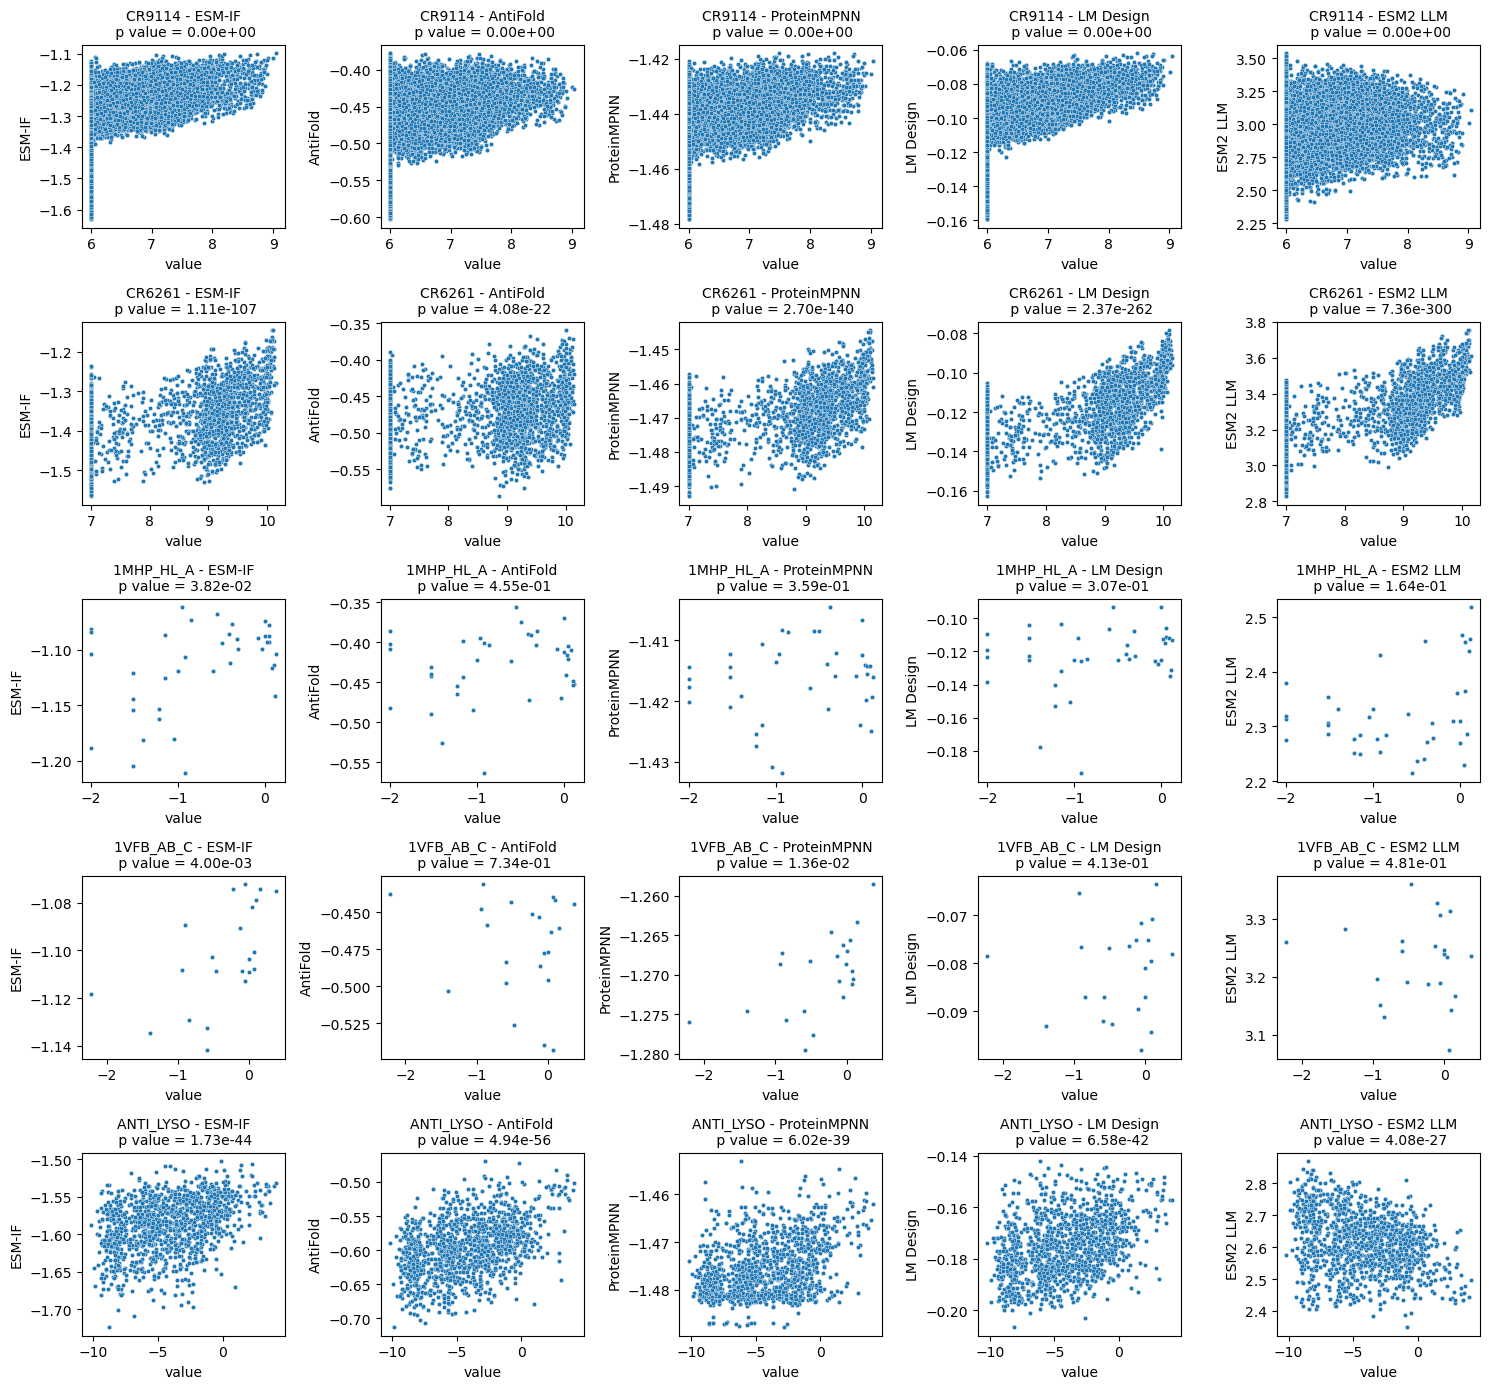

In [6]:
def plot_corelation2(df):
    from scipy.stats import spearmanr

    fig, axes = plt.subplots(5, 5, figsize=(15, 14))
    axes_flat = axes.flatten()
    for i, data_id in enumerate(DMS_info.keys()):
    
        df_data = df[df['data_id'] == data_id]
        df_data = df_data[df_data['mut_chain'] == 'H']
        
        metrics = ['ESM-IF', 'AntiFold', 'ProteinMPNN', 'LM Design', 'ESM2 LLM']
        for j, metric in enumerate(metrics):
            df_data = df_data.dropna(subset=['value', metric])

            ax = axes_flat[len(metrics)*i+j]
            sns.scatterplot(data=df_data, x='value', y=metric, ax=ax, s=10)
            ax.set_title(f"{data_id} - {metric}")

            # 计算Spearman相关系数
            rho, p_value = spearmanr(df_data['value'], df_data[metric])
            
            # 在图中显示相关系数（rho值），保留两位小数
            ax.set_title(f"{data_id} - {metric}\n p value = {p_value:.2e}", fontsize=10)
            # ax.set_title(f"p value = {p_value:.1e}", fontsize=10)



    plt.tight_layout()
    plt.show()

plot_corelation2(df_all)

In [7]:
def collect_result_df(df):
    metrics = ['ESM-IF', 'AntiFold', 'ProteinMPNN', 'LM Design', 'ESM2 LLM', 'xTrimo-1b LLM']
    data_ids = []
    methods = []
    cors = []
    df = df.dropna(subset= ['value'] + metrics )
    for i, data_id in enumerate(DMS_info.keys()):
        df_data = df[df['data_id'] == data_id]
        df_data = df_data[df_data['mut_chain'] == 'H']
        
        for j, metric in enumerate(metrics):
            correlation = np.corrcoef(df_data['value'], df_data[metric])[0, 1]
            data_ids.append(data_id)
            methods.append(metric)
            cors.append(correlation)

    df = df.dropna(subset=['value'] + metrics)
    for i, data_id in enumerate(['CR9114', 'CR6261']):
    
        df_data = df[df['data_id'] == data_id]
        df_data = df_data[df_data['mut_chain'] == 'H']
        
        for j, metric in enumerate(metrics):
            correlation = np.corrcoef(df_data['value2'], df_data[metric])[0, 1]
            data_ids.append(data_id+'_2')
            methods.append(metric)
            cors.append(correlation)

    
    df = pd.DataFrame({
        'data_id': data_ids,
        'method' :methods,
        'corelation': cors
    })

    return df

In [8]:
df_analysis = collect_result_df(df_all)

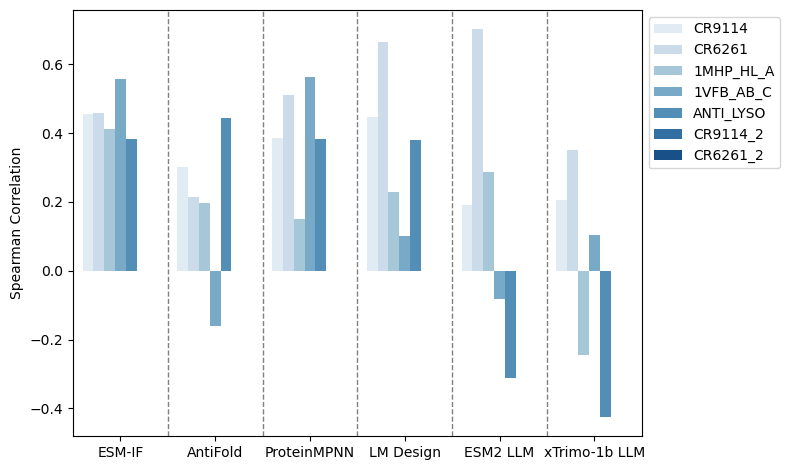

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图片大小
plt.figure(figsize=(10*0.8, 6*0.8))  # 宽度 10 英寸，高度 6 英寸

palette = sns.color_palette("Blues", n_colors=df_analysis['data_id'].nunique())  # 使用"muted"调色板
# 创建条形图
ax = sns.barplot(data=df_analysis, hue="data_id", y="corelation", x="method", palette=palette)
ax.set_xlabel("")
ax.set_ylabel("Spearman Correlation")

# 设置图例，去掉标题并将其放置到外部
legend = ax.legend_
legend.set_title("")  # 去掉图例标题
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 将图例放置在图表外部

# 添加虚线进行分割
# 获取每个 method 对应的 x 轴位置
methods = df_analysis['method'].unique()
num_methods = len(methods)

# 绘制虚线来分隔不同的 method
for i in range(1, num_methods):
    ax.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=1)

# 自动调整布局，避免标签重叠
plt.tight_layout()
plt.savefig("../results/fig-9.png", dpi=300, bbox_inches='tight')  # bbox_inches='tight' 保证内容紧凑

# 显示图表
plt.show()
